`ApJdataFrames` Slesnick2006
---
`Title`: A LARGE-AREA SEARCH FOR LOW-MASS OBJECTS IN UPPER SCORPIUS. I. THE PHOTOMETRIC CAMPAIGN AND NEW BROWN DWARFS   
`Authors`: CATHERINE L. SLESNICK, JOHN M. CARPENTER, AND LYNNE A. HILLENBRAND  

Data is from this paper:
http://iopscience.iop.org/1538-3881/131/6/3016/fulltext/205148.html

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Table 1- Measured Quantities for PMS Candidates with Observed Spectra

In [3]:
import pandas as pd

In [4]:
names = ["ID","R","I","J","H","KS","TiO_7140","TiO_8465","NaI_8189","Spectral Type","EW_Ha","Gravity"]
tbl1 = pd.read_csv("http://iopscience.iop.org/1538-3881/131/6/3016/fulltext/205148.tb1.txt",
                   sep='\t', names=names, skip_blank_lines=True, na_values='\ldots')
tbl1.head()

,ID,R,I,J,H,KS,TiO_7140,TiO_8465,NaI_8189,Spectral Type,EW_Ha,Gravity
0,SCH 15563309-18074323,19.7,16.5,14.18,13.61,13.13,3.22,1.80,0.81,M7,NaN,Dwarf
1,SCH 15582384-15310335,16.1,13.9,12.36,11.79,11.52,1.76,1.16,0.83,M4.5,-5.4,Dwarf
2,SCH 15583162-24025411,17.5,15.0,13.16,12.51,12.20,1.95,1.25,0.93,M4.5,-7.6,USco
3,SCH 15594802-22271650,19.1,16.5,14.24,13.56,13.16,2.78,1.90,0.93,M7.5,-15.2,USco
4,SCH 16014768-24410152,18.5,15.9,13.87,13.27,13.00,2.44,1.45,0.86,M5,-16.0,USco


## Table 2 - Derived Quantities for New USco Members

In [5]:
names = ["ID","MJ","AV","log_Teff","log_L_bol"]
tbl2 = pd.read_csv("http://iopscience.iop.org/1538-3881/131/6/3016/fulltext/205148.tb2.txt",
                   sep='\t', names=names, skip_blank_lines=True, na_values='\ldots')
tbl2.head()

,ID,MJ,AV,log_Teff,log_L_bol
0,SCH 15583162-24025411,7.18,0.66,3.48,-1.76
1,SCH 15594802-22271650,8.35,0.33,3.41,-2.27
2,SCH 16014768-24410152,8.03,0.15,3.47,-2.11
3,SCH 16040453-23463795,5.64,1.14,3.49,-1.13
4,SCH 16044303-23182620,7.99,0.05,3.43,-2.12


# Save the data tables locally.

    mkdir ../data/Slesnick2006

In [7]:
tbl1.to_csv("../data/Slesnick2006/tbl1.csv", sep="\t", index=False)
tbl2.to_csv("../data/Slesnick2006/tbl2.csv", sep="\t", index=False)

# Make a plot

In [8]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
import gully_custom

In [10]:
SpT, _, _, _ = gully_custom.specTypePlus(tbl1["Spectral Type"])

Turn the ratio into an equivalent width:

$EW = (1 - \frac{F_{\lambda_{8189}}}{F_{\lambda_{8150}}})\Delta \lambda$

In [11]:
EW_NaI_8189 = (1.0 - tbl1.NaI_8189.values)*30.0

(-5, 8.5)

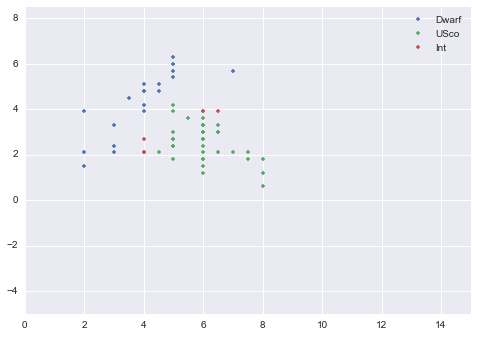

In [12]:
c = 'Dwarf'
i = tbl1.Gravity.values == c
plt.plot(SpT[i], EW_NaI_8189[i], '.', label = c)
c = 'USco'
i = tbl1.Gravity.values == c
plt.plot(SpT[i], EW_NaI_8189[i], '.', label = c)

c = 'Int'
i = tbl1.Gravity.values == c
plt.plot(SpT[i], EW_NaI_8189[i], '.', label = c)

plt.legend(loc='best')
plt.xlim(0, 15)
plt.ylim(-5, 8.5)

In [13]:
EW_NaI_8189[tbl1.Gravity.values == 'USco']

array([ 2.1,  2.1,  4.2,  3. ,  3.3,  3.3,  3.3,  3.3,  1.2,  1.8,  1.8,
        2.1,  3.9,  3. ,  3. ,  3.6,  3. ,  2.1,  3.9,  2.7,  2.7,  2.4,
        3.3,  3.6,  3. ,  2.4,  0.6,  1.2,  1.5,  1.8,  1.8,  2.1,  3. ,
        1.8,  3. ,  2.7,  2.4,  2.7])

# Match the sources to SIMBAD
This will make it easier to get the coordinates, and query other properties.

In [14]:
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u

In [20]:
customSimbad.list_votable_fields()

--NOTES--

1. The parameter filtername must correspond to an existing filter. Filters include: B,V,R,I,J,K,L.  They are checked by SIMBAD but not astroquery.simbad

2. Fields beginning with rvz display the data as it is in the database. Fields beginning with rv force the display as a radial velocity. Fields beginning with z force the display as a redshift

3. For each measurement catalog, the VOTable contains all fields of the first measurement. When applicable, the first measurement is the mean one. 

          col0                   col1              col2     
------------------------ -------------------- --------------
      bibcodelist(y1-y2) fluxdata(filtername)       plx_qual
                     cel                 gcrv             pm
                    cl.g                  gen     pm_bibcode
                coo(opt)                   gj   pm_err_angle
             coo_bibcode                 hbet    pm_err_maja
           coo_err_angle                hbet1    pm_err_mina
    

In [47]:
bands = ['U','B','V','R','I','J','H','K','u','g','r','i','z']
fluxes = ['fluxdata({})'.format(band) for band in bands]
flux_cols = sum([['FLUX_{}'.format(band), 'FLUX_ERROR_{}'.format(band)] for band in bands], [])

In [30]:
customSimbad = Simbad()
customSimbad.add_votable_fields('otype', 'id', 'sptype', 'flux(U)','flux_error(U)''flux(B)','flux_error(B)''flux(V)','flux_error(V)''flux(R)','flux_error(R)''flux(I)','flux_error(I)''flux(J)','flux_error(J)''flux(H)','flux_error(H)''flux(K)','flux_error(K)''flux(u)','flux_error(u)''flux(g)','flux_error(g)''flux(r)','flux_error(r)''flux(i)','flux_error(i)''flux(z)','flux_error(z)')

SCH is a non-standard input for Simbad.  Need to put in the 2MASS coordinates.

In [31]:
input_to_simbad = "[SCH2006] J"+tbl2.ID.str.strip("SCH ")

In [32]:
result = customSimbad.query_objects(input_to_simbad, verbose=True)

In [34]:
result.columns

<TableColumns names=('MAIN_ID','RA','DEC','RA_PREC','DEC_PREC','COO_ERR_MAJA','COO_ERR_MINA','COO_ERR_ANGLE','COO_QUAL','COO_WAVELENGTH','COO_BIBCODE','OTYPE','ID','SP_TYPE','SP_QUAL','SP_NATURE','SP_BIBCODE','FLUX_U','FLUX_ERROR_U','FLUX_B','FLUX_ERROR_B','FLUX_V','FLUX_ERROR_V','FLUX_R','FLUX_ERROR_R','FLUX_I','FLUX_ERROR_I','FLUX_J','FLUX_ERROR_J','FLUX_H','FLUX_ERROR_H','FLUX_K','FLUX_ERROR_K','FLUX_u','FLUX_ERROR_u','FLUX_g','FLUX_ERROR_g','FLUX_r','FLUX_ERROR_r','FLUX_i','FLUX_ERROR_i','FLUX_z','FLUX_ERROR_z')>

In [50]:
result[flux_cols][0:5]

FLUX_U,FLUX_ERROR_U,FLUX_B,FLUX_ERROR_B,FLUX_V,FLUX_ERROR_V,FLUX_R,FLUX_ERROR_R,FLUX_I,FLUX_ERROR_I,FLUX_J,FLUX_ERROR_J,FLUX_H,FLUX_ERROR_H,FLUX_K,FLUX_ERROR_K,FLUX_u,FLUX_ERROR_u,FLUX_g,FLUX_ERROR_g,FLUX_r,FLUX_ERROR_r,FLUX_i,FLUX_ERROR_i,FLUX_z,FLUX_ERROR_z
mag,,mag,,mag,,mag,,mag,,mag,,mag,,mag,,mag,,mag,,mag,,mag,,mag,
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
--,--,--,--,--,--,17.5,--,15.0,--,13.16,0.021,12.511,0.027,12.204,0.029,--,--,--,--,18.049999,--,16.02,--,--,--
--,--,--,--,--,--,19.1,--,16.5,--,14.242,0.030,13.565,0.037,13.162,0.037,--,--,--,--,19.83,--,17.49,--,--,--
--,--,--,--,--,--,18.5,--,15.9,--,13.874,0.029,13.278,0.029,13.006,0.030,--,--,--,--,19.08,--,16.92,--,--,--
--,--,--,--,--,--,15.3,--,13.3,--,11.744,0.023,11.047,0.024,10.73,0.025,--,--,17.190001,--,15.76,--,14.15,--,--,--
--,--,--,--,--,--,19.0,--,15.9,--,13.812,0.024,13.196,0.030,12.857,0.030,--,--,--,--,19.5,--,17.17,--,--,--


In [51]:
print "There were {} sources queried, and {} sources found.".format(len(input_to_simbad), len(result))
if len(input_to_simbad) == len(result):
    print "Hooray!  Everything matched"
else:
    print "Which ones were not found?"

There were 43 sources queried, and 43 sources found.
Hooray!  Everything matched


## Merge the catalogs

In [19]:
tbl2["Simbad_name"] = input_to_simbad
result["Simbad_name"] = input_to_simbad
simbad_df = result.to_pandas()
del simbad_df["ID"]

In [20]:
tbl2_simbad = pd.merge(tbl2, simbad_df, on="Simbad_name")
tbl2_simbad.columns

Index([u'ID', u'MJ', u'AV', u'log_Teff', u'log_L_bol', u'Simbad_name', u'MAIN_ID', u'RA', u'DEC', u'RA_PREC', u'DEC_PREC', u'COO_ERR_MAJA', u'COO_ERR_MINA', u'COO_ERR_ANGLE', u'COO_QUAL', u'COO_WAVELENGTH', u'COO_BIBCODE', u'OTYPE', u'SP_TYPE', u'SP_QUAL', u'SP_NATURE', u'SP_BIBCODE'], dtype='object')

In [21]:
tbl2_simbad[[u'MAIN_ID', u'ID', u'RA', u'DEC', u'MJ', u'AV', u'log_Teff', u'log_L_bol',u'OTYPE',
             u'SP_TYPE', u'SP_BIBCODE']].head()

,MAIN_ID,ID,RA,DEC,MJ,AV,log_Teff,log_L_bol,OTYPE,SP_TYPE,SP_BIBCODE
0,2MASS J15583162-2402538,SCH 15583162-24025411,15 58 31.626,-24 02 53.86,7.18,0.66,3.48,-1.76,pMS*,M4.5,2006AJ....131.3016S
1,2MASS J15594802-2227162,SCH 15594802-22271650,15 59 48.021,-22 27 16.29,8.35,0.33,3.41,-2.27,pMS*,M7.5,2006AJ....131.3016S
2,2MASS J16014769-2441011,SCH 16014768-24410152,16 01 47.695,-24 41 01.13,8.03,0.15,3.47,-2.11,pMS*,M5,2006AJ....131.3016S
3,2MASS J16040453-2346377,SCH 16040453-23463795,16 04 04.538,-23 46 37.71,5.64,1.14,3.49,-1.13,pMS*,M4,2006AJ....131.3016S
4,2MASS J16044303-2318258,SCH 16044303-23182620,16 04 43.036,-23 18 25.90,7.99,0.05,3.43,-2.12,pMS*,M6.5,2006AJ....131.3016S


In [22]:
tbl2_simbad.to_csv("../data/Slesnick2006/tbl2_plusSimbad.csv", index=False)

**The end.**